### Mobilenet dataset loader


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(
    source, batch_size, transform, eval_transform=None, root="data", split_ratio=0.1
):
    if eval_transform is None:
        eval_transform = transform

    trainset = source(
        root=root,
        train=True,
        download=True,
        transform=transform,
    )
    testset = source(
        root=root,
        train=False,
        download=True,
        transform=eval_transform,
    )

    trainset, valset = torch.utils.data.random_split(
        trainset,
        [int((1 - split_ratio) * len(trainset)), int(split_ratio * len(trainset))],
    )

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, testloader


def get_cifar10_loaders(batch_size, root="data/cifar10", split_ratio=0.1):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    eval_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    return get_loaders(
        datasets.CIFAR10,
        batch_size,
        transform,
        eval_transform=eval_transform,
        root=root,
        split_ratio=split_ratio,
    )


DATALOADERS = {
    "cifar10": get_cifar10_loaders,
}

if __name__ == "__main__":
    datasets_to_load = ["cifar10"]
    for dataset in datasets_to_load:
        trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
        print(f'{dataset}: {len(trainloader.dataset)}, {len(valloader.dataset)}, {len(testloader.dataset)}, {trainloader.dataset[0][0].shape}')



100%|██████████| 170M/170M [00:02<00:00, 73.0MB/s] 


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified
cifar10: 45000, 5000, 10000, torch.Size([3, 32, 32])


In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



### mobilenetv1

#### Implement your model based on the given model architecture in the lab material.



In [3]:
import torch
import torch.nn as nn
import torch.ao.quantization as tq

class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution Block: Depthwise Conv2d + Pointwise Conv2d"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Depthwise Convolution (3x3, groups=in_channels)
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                in_channels, in_channels, kernel_size=3, stride=stride, padding=1, 
                groups=in_channels, bias=False
            ),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        # Pointwise Convolution (1x1)
        self.pointwise = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

    def fuse_modules(self):
        """Fuse Conv2d, BatchNorm2d, and ReLU for quantization"""
        tq.fuse_modules(self.depthwise, ['0', '1', '2'], inplace=True)
        tq.fuse_modules(self.pointwise, ['0', '1', '2'], inplace=True)

class MobileNetV1(nn.Module):
    """MobileNetV1 adapted for CIFAR-10 with final output 2x2x1024 → 1x1x1024"""
    def __init__(self, in_channels=3, in_size=32, num_classes=10):
        super().__init__()
        
        # Initial Conv2d layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Depthwise Separable Convolution layers
        self.layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1),    # 32x32x64
            DepthwiseSeparableConv(64, 128, stride=2),   # 16x16x128
            DepthwiseSeparableConv(128, 128, stride=1),  # 16x16x128
            DepthwiseSeparableConv(128, 256, stride=2),  # 8x8x256
            DepthwiseSeparableConv(256, 256, stride=1),  # 8x8x256
            DepthwiseSeparableConv(256, 512, stride=2),  # 4x4x512
            DepthwiseSeparableConv(512, 512, stride=1),  # 4x4x512 
            DepthwiseSeparableConv(512, 1024, stride=2), # 2x2x1024
        )
        
        # Global average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 2x2x1024 → 1x1x1024
        self.fc = nn.Linear(1024, num_classes)  # 1024 → 10
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layers(x)
        x = self.avgpool(x)                     # 2x2x1024 → 1x1x1024
        x = torch.flatten(x, start_dim=1)       # 1x1x1024 → 1024
        x = self.fc(x)                          # 1024 → 10
        return x
    
    def fuse_modules(self):
        """Fuse Conv2d, BatchNorm2d, and ReLU for quantization"""
        self.conv1.eval()
        tq.fuse_modules(self.conv1, ['0', '1', '2'], inplace=True)
        for layer in self.layers:
            layer.eval()
            layer.fuse_modules()
        self.eval()

if __name__ == "__main__":
    model = MobileNetV1()
    inputs = torch.randn(1, 3, 32, 32)
    print(model)
    from torchsummary import summary
    summary(model, (3, 32, 32), device="cpu")

MobileNetV1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layers): Sequential(
    (0): DepthwiseSeparableConv(
      (depthwise): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): DepthwiseSeparableConv(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [4]:
from enum import Enum
import math

import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, raw_scale: float, max_shift_amount=8) -> float:
        if raw_scale <= 0:
            return 2.0 ** (-max_shift_amount)

        # log2(raw_scale)
        log2_scale = math.log2(raw_scale)

        log2_scale_clamped = max(-max_shift_amount, min(log2_scale, max_shift_amount))

        exponent_rounded = round(log2_scale_clamped)
        approx_scale = 2.0 ** exponent_rounded

        return approx_scale

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        # 2max(∣α∣,∣β∣)/q_max-q_min
        max_abs_val = max(abs(min_val), abs(max_val))

        if max_abs_val == 0:
            max_abs_val = 1e-7

        raw_scale = 2 * max_abs_val / 255

        # power-of-two
        scale = self.scale_approximate(raw_scale)

        if self.dtype == torch.quint8:
        # For activation : UINT8
            zero_point = 128
        elif self.dtype == torch.qint8:
        # For weight : INT8
            zero_point = 0

        # 轉 PyTorch Tensor
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int32)

        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=PowerOfTwo"


class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None


### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  1/30  lr=1.00e-03, train_loss=1.5816, val_loss=1.3431, train_acc=0.4187, val_acc=0.5078
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  2/30  lr=1.00e-03, train_loss=1.2056, val_loss=1.0967, train_acc=0.5687, val_acc=0.6104
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  3/30  lr=1.00e-03, train_loss=1.0072, val_loss=0.9871, train_acc=0.6417, val_acc=0.6464
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  4/30  lr=1.00e-03, train_loss=0.8817, val_loss=0.8626, train_acc=0.6884, val_acc=0.6912
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  5/30  lr=1.00e-03, train_loss=0.7892, val_loss=0.7939, train_acc=0.7219, val_acc=0.7200
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  6/30  lr=1.00e-03, train_loss=0.7124, val_loss=0.7182, train_acc=0.7523, val_acc=0.7508
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  7/30  lr=1.00e-03, train_loss=0.6524, val_loss=0.6510, train_acc=0.7696, val_acc=0.7744
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  8/30  lr=1.00e-03, train_loss=0.6022, val_loss=0.6450, train_acc=0.7888, val_acc=0.7816
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  9/30  lr=1.00e-03, train_loss=0.5688, val_loss=0.5964, train_acc=0.8010, val_acc=0.7922
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/30  lr=1.00e-03, train_loss=0.5416, val_loss=0.5743, train_acc=0.8103, val_acc=0.8000
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/30  lr=5.00e-04, train_loss=0.4595, val_loss=0.5164, train_acc=0.8395, val_acc=0.8188
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/30  lr=5.00e-04, train_loss=0.4304, val_loss=0.4985, train_acc=0.8505, val_acc=0.8334
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/30  lr=5.00e-04, train_loss=0.4130, val_loss=0.4842, train_acc=0.8576, val_acc=0.8342
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/30  lr=5.00e-04, train_loss=0.3927, val_loss=0.4863, train_acc=0.8633, val_acc=0.8322


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/30  lr=5.00e-04, train_loss=0.3800, val_loss=0.4830, train_acc=0.8662, val_acc=0.8326


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/30  lr=5.00e-04, train_loss=0.3665, val_loss=0.4842, train_acc=0.8728, val_acc=0.8370
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/30  lr=5.00e-04, train_loss=0.3527, val_loss=0.4663, train_acc=0.8760, val_acc=0.8390
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/30  lr=5.00e-04, train_loss=0.3430, val_loss=0.4650, train_acc=0.8802, val_acc=0.8424
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/30  lr=5.00e-04, train_loss=0.3332, val_loss=0.4748, train_acc=0.8826, val_acc=0.8448
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/30  lr=5.00e-04, train_loss=0.3222, val_loss=0.4570, train_acc=0.8880, val_acc=0.8454
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/30  lr=2.50e-04, train_loss=0.2820, val_loss=0.4411, train_acc=0.9025, val_acc=0.8546
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/30  lr=2.50e-04, train_loss=0.2648, val_loss=0.4257, train_acc=0.9070, val_acc=0.8548
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/30  lr=2.50e-04, train_loss=0.2557, val_loss=0.4379, train_acc=0.9106, val_acc=0.8630
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/30  lr=2.50e-04, train_loss=0.2484, val_loss=0.4161, train_acc=0.9124, val_acc=0.8610


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/30  lr=2.50e-04, train_loss=0.2373, val_loss=0.4434, train_acc=0.9170, val_acc=0.8586


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/30  lr=2.50e-04, train_loss=0.2354, val_loss=0.4204, train_acc=0.9169, val_acc=0.8632
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/30  lr=2.50e-04, train_loss=0.2287, val_loss=0.4191, train_acc=0.9196, val_acc=0.8634
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/30  lr=2.50e-04, train_loss=0.2217, val_loss=0.4293, train_acc=0.9222, val_acc=0.8592


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/30  lr=2.50e-04, train_loss=0.2159, val_loss=0.4433, train_acc=0.9239, val_acc=0.8658
Model saved at weights/cifar10/mobilenetv1.pt (4.395602 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/30  lr=2.50e-04, train_loss=0.2110, val_loss=0.4228, train_acc=0.9253, val_acc=0.8656


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test: loss=0.4241, accuracy=0.8733
Model size: 4.40 MB
Plot saved at figure/cifar10/mobilenetv1.png
Time: 804.15s


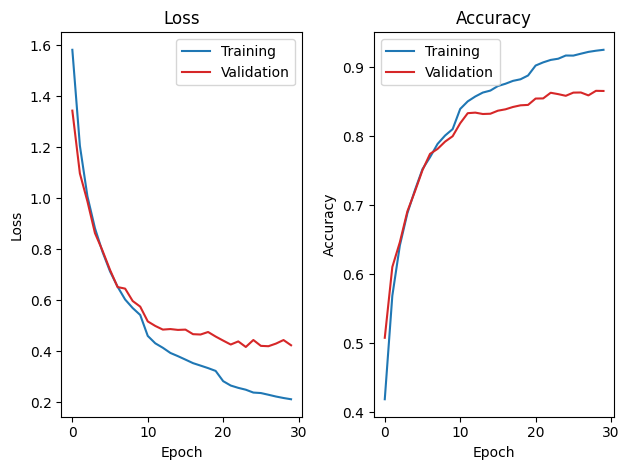

In [5]:
import os
import time

import torch
from torch import nn,optim
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm

reset_seed(10)


def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)

    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(
            model, trainloader, criterion, optimizer
        )
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={scheduler.get_last_lr()[0]:.2e}", end=", ")
        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")

        if _val_acc >= max(val_acc):
            save_model(model, save_path, existed="overwrite")

        if scheduler is not None:
            scheduler.step()

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc


def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = f"{dataset}/{network.__name__.lower()}"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(in_channels, in_size).to(DEFAULT_DEVICE)
    ######### Implement your code here ##########
    # Cross Entropy Loss
    criterion = nn.CrossEntropyLoss()

    # optimizer => Adam
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # scheduler => StepLR
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    ##########################################

    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=f"weights/{name}.pt",
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    print(f"Model size: {os.path.getsize(f'weights/{name}.pt') / 1e6:.2f} MB")

    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, f"figure/{name}.png")
    print(f"Time: {time.time() - t:.2f}s")


if __name__ == "__main__":
    for network in [MobileNetV1]:
        """ You can adjust the number of epochs """
        EPOCHS = 30
        main(epochs=EPOCHS, network=network, dataset="cifar10")



### PTQ on VGG Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [6]:
import os
import torch
from torch import nn
import torch.ao.quantization as tq
import torchvision
import torchvision.transforms as transforms

def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cpu"
reset_seed(0)

def calibrate(model, loader, device=DEVICE):
    model.eval().to(device)
    with torch.no_grad():
        for x, _ in loader:
            model(x.to(device))
            break

def main(network, verbose=True):
    # Configuration
    dataset = 'cifar10'
    backend = 'power2'
    model_path = "weights/cifar10/mobilenetv1.pt"  # Pre-trained FP32 weights
    save_path = './weights/cifar10/mobilenetv1-power2.pt'  # INT8 output

    # Load calibration data
    *_, test_loader = DATALOADERS[dataset](batch_size=1)

    # Load pre-trained model
    model = network(in_channels=3, in_size=32, num_classes=10).eval().to("cpu")
    model.load_state_dict(torch.load(model_path, map_location="cpu", weights_only=True))

    # Fuse modules
    model.fuse_modules()

    # Configure quantization
    model = tq.QuantWrapper(model)
    model.qconfig = CustomQConfig.POWER2.value
    print(f"Quantization backend: {model.qconfig}")
    if verbose:
        print("Quantization configuration set to:", model.qconfig)

    # Apply quantization preparation
    tq.prepare(model, inplace=True)

    # Calibration
    calibrate(model, test_loader, "cpu")

    # Convert to quantized model
    tq.convert(model, inplace=True)

    # Save quantized model
    save_model(model, save_path, verbose=True, existed="keep_both")
    if verbose:
        print(f"Quantized model saved as '{save_path}'")

if __name__ == "__main__":
    main(network=MobileNetV1, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
Quantization backend: QConfig(activation=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.quint8, qscheme=torch.per_tensor_symmetric){}, weight=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
Quantization configuration set to: QConfig(activation=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.quint8, qscheme=torch.per_tensor_symmetric){}, weight=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
Model saved at ./weights/cifar10/mobilenetv1-power2.pt (1.117842 MB)
Quantized model saved as './weights/cifar10/mobilenetv1-power2.pt'


### Evaluate Quantized Model


In [7]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

def main():
    dataset = 'cifar10'
    backend = 'power2'
    model_path = './weights/cifar10/mobilenetv1-power2.pt'

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
    else:
        qconfig = None
        fuse_modules = False
    model = load_model(MobileNetV1(in_channels, in_size), model_path, qconfig=qconfig, fuse_modules=fuse_modules)
    print(model)

    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )


if __name__ == "__main__":
    main()



Files already downloaded and verified
Files already downloaded and verified
Fusing modules
Model loaded from ./weights/cifar10/mobilenetv1-power2.pt (1.117842 MB)
QuantWrapper(
  (quant): Quantize(scale=tensor([0.0156]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): MobileNetV1(
    (conv1): Sequential(
      (0): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.015625, zero_point=128, padding=(1, 1))
      (1): Identity()
      (2): Identity()
    )
    (layers): Sequential(
      (0): DepthwiseSeparableConv(
        (depthwise): Sequential(
          (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.0625, zero_point=128, padding=(1, 1), groups=32)
          (1): Identity()
          (2): Identity()
        )
        (pointwise): Sequential(
          (0): QuantizedConvReLU2d(32, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.03125, zero_point=128)
          (1): Identity()
          (2): Identity()
 

/tmp/ipykernel_31/2912952992.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename, map_location=device))
/usr/local/lib/python3.11

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test: loss=0.4124, accuracy=0.8694, size=1.117842MB
